# Phân tích và trực quan hóa mạng nghệ sĩ Hàn Quốc

Notebook này tải file JSON kết quả (`korean_artists_graph_bfs.json`), tổng hợp thống kê và vẽ một số biểu đồ/đồ thị mạng cơ bản.

Yêu cầu môi trường: pandas, matplotlib, networkx, plotly (tùy chọn).


In [5]:
# Cài đặt bổ sung (nếu cần) - có thể bỏ qua nếu đã có
# !pip install pandas matplotlib networkx plotly

import json
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

try:
    import networkx as nx
except ImportError:
    nx = None

DATA_PATH = Path('korean_artists_graph_bfs.json')
assert DATA_PATH.exists(), f"Không tìm thấy file {DATA_PATH.resolve()}"

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

nodes = data.get('nodes', {})
edges = data.get('edges', [])
stats = data.get('statistics', {})

print(f"Nodes: {len(nodes):,} | Edges: {len(edges):,}")



Nodes: 1,974 | Edges: 3,403


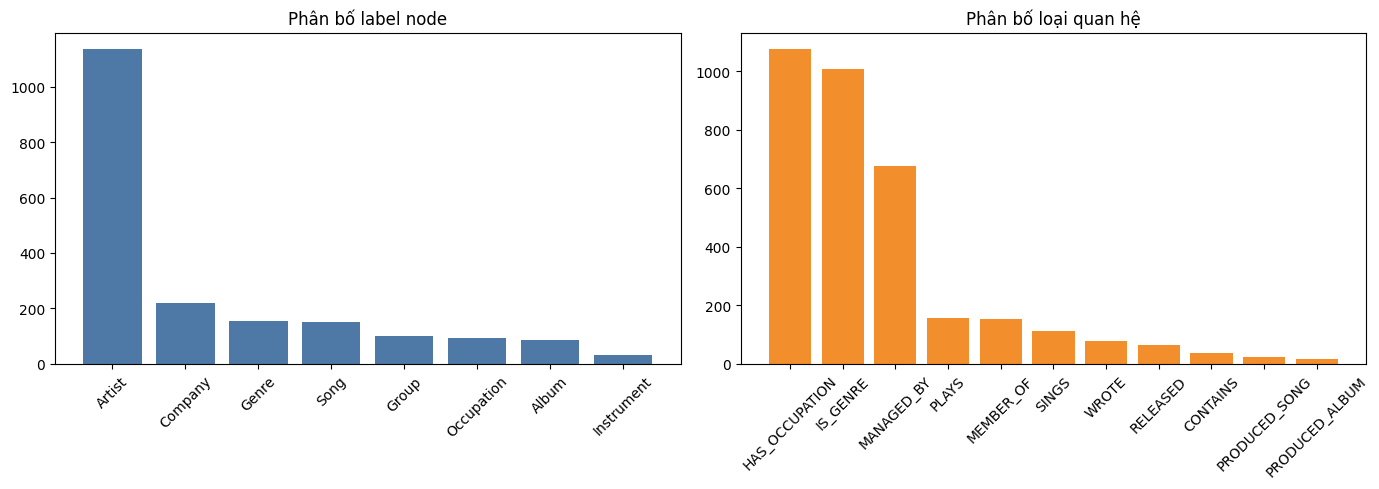

(     label  count
 1   Artist   1137
 4  Company    218
 5    Genre    156
 3     Song    150
 0    Group    100,
               type  count
 7   HAS_OCCUPATION   1077
 9         IS_GENRE   1006
 8       MANAGED_BY    675
 10           PLAYS    158
 0        MEMBER_OF    155)

In [6]:
# Thống kê theo label và loại cạnh
label_counts = Counter([node.get('label', 'Unknown') for node in nodes.values()])
edge_type_counts = Counter([e.get('type', 'RELATED_TO') for e in edges])

label_df = pd.DataFrame(label_counts.items(), columns=['label', 'count']).sort_values('count', ascending=False)
edge_df = pd.DataFrame(edge_type_counts.items(), columns=['type', 'count']).sort_values('count', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(label_df['label'], label_df['count'], color='#4E79A7')
axes[0].set_title('Phân bố label node')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(edge_df['type'], edge_df['count'], color='#F28E2B')
axes[1].set_title('Phân bố loại quan hệ')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

label_df.head(), edge_df.head()


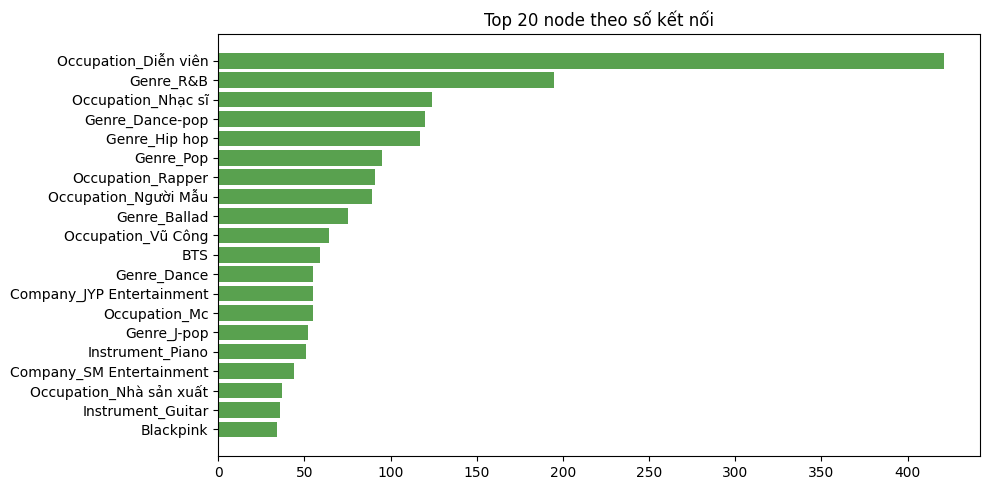

In [7]:
# Top node theo độ kết nối (nếu networkx khả dụng)
if nx is not None:
    G = nx.Graph()
    for key, n in nodes.items():
        G.add_node(key, **n)
    for e in edges:
        s, t = e.get('source'), e.get('target')
        if s in nodes and t in nodes:
            G.add_edge(s, t, **e)

    deg = dict(G.degree())
    top_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:20]
    top_df = pd.DataFrame(top_deg, columns=['node', 'degree'])
    top_df['label'] = top_df['node'].map(lambda k: nodes[k].get('label'))

    plt.figure(figsize=(10,5))
    plt.barh(top_df['node'][::-1], top_df['degree'][::-1], color='#59A14F')
    plt.title('Top 20 node theo số kết nối')
    plt.tight_layout()
    plt.show()

    top_df.head(10)
else:
    print('networkx chưa cài, bỏ qua bước tính độ.')


In [14]:
# Top 5 node có nhiều kết nối nhất cho mỗi loại label
import pandas as pd

if nx is not None:
    # Bảo đảm có graph G
    if 'G' not in globals():
        G = nx.Graph()
        for key in nodes:
            G.add_node(key)
        for e in edges:
            s, t = e.get('source'), e.get('target')
            if s in nodes and t in nodes:
                G.add_edge(s, t)

    degree_map = dict(G.degree())
    label_map = {k: v.get('label') for k, v in nodes.items()}
    title_map = {k: v.get('title', k) for k, v in nodes.items()}

    deg_df = pd.DataFrame([
        {'id': nid, 'title': title_map.get(nid, nid), 'label': label_map.get(nid, 'Unknown'), 'degree': deg}
        for nid, deg in degree_map.items()
    ])

    top5_by_label = (
        deg_df.sort_values(['label', 'degree'], ascending=[True, False])
              .groupby('label', as_index=False)
              .head(5)
              .reset_index(drop=True)
    )

    display(top5_by_label)
else:
    print('networkx chưa cài, bỏ qua bước này')


,id,title,label,degree
0,The Album (album của Blackpink),The Album (album của Blackpink),Album,7
1,Be (album của BTS),Be (album của BTS),Album,5
2,Face Yourself,Face Yourself,Album,5
3,OMG (album đĩa đơn),OMG (album đĩa đơn),Album,4
4,Youth (album của BTS),Youth (album của BTS),Album,4
5,Pdogg,Pdogg,Artist,27
6,Teddy Park,Teddy Park,Artist,24
7,J-Hope,J-Hope,Artist,23
8,Yoo Young-jin,Yoo Young-jin,Artist,22
9,Jung Yong Hwa,Jung Yong Hwa,Artist,20


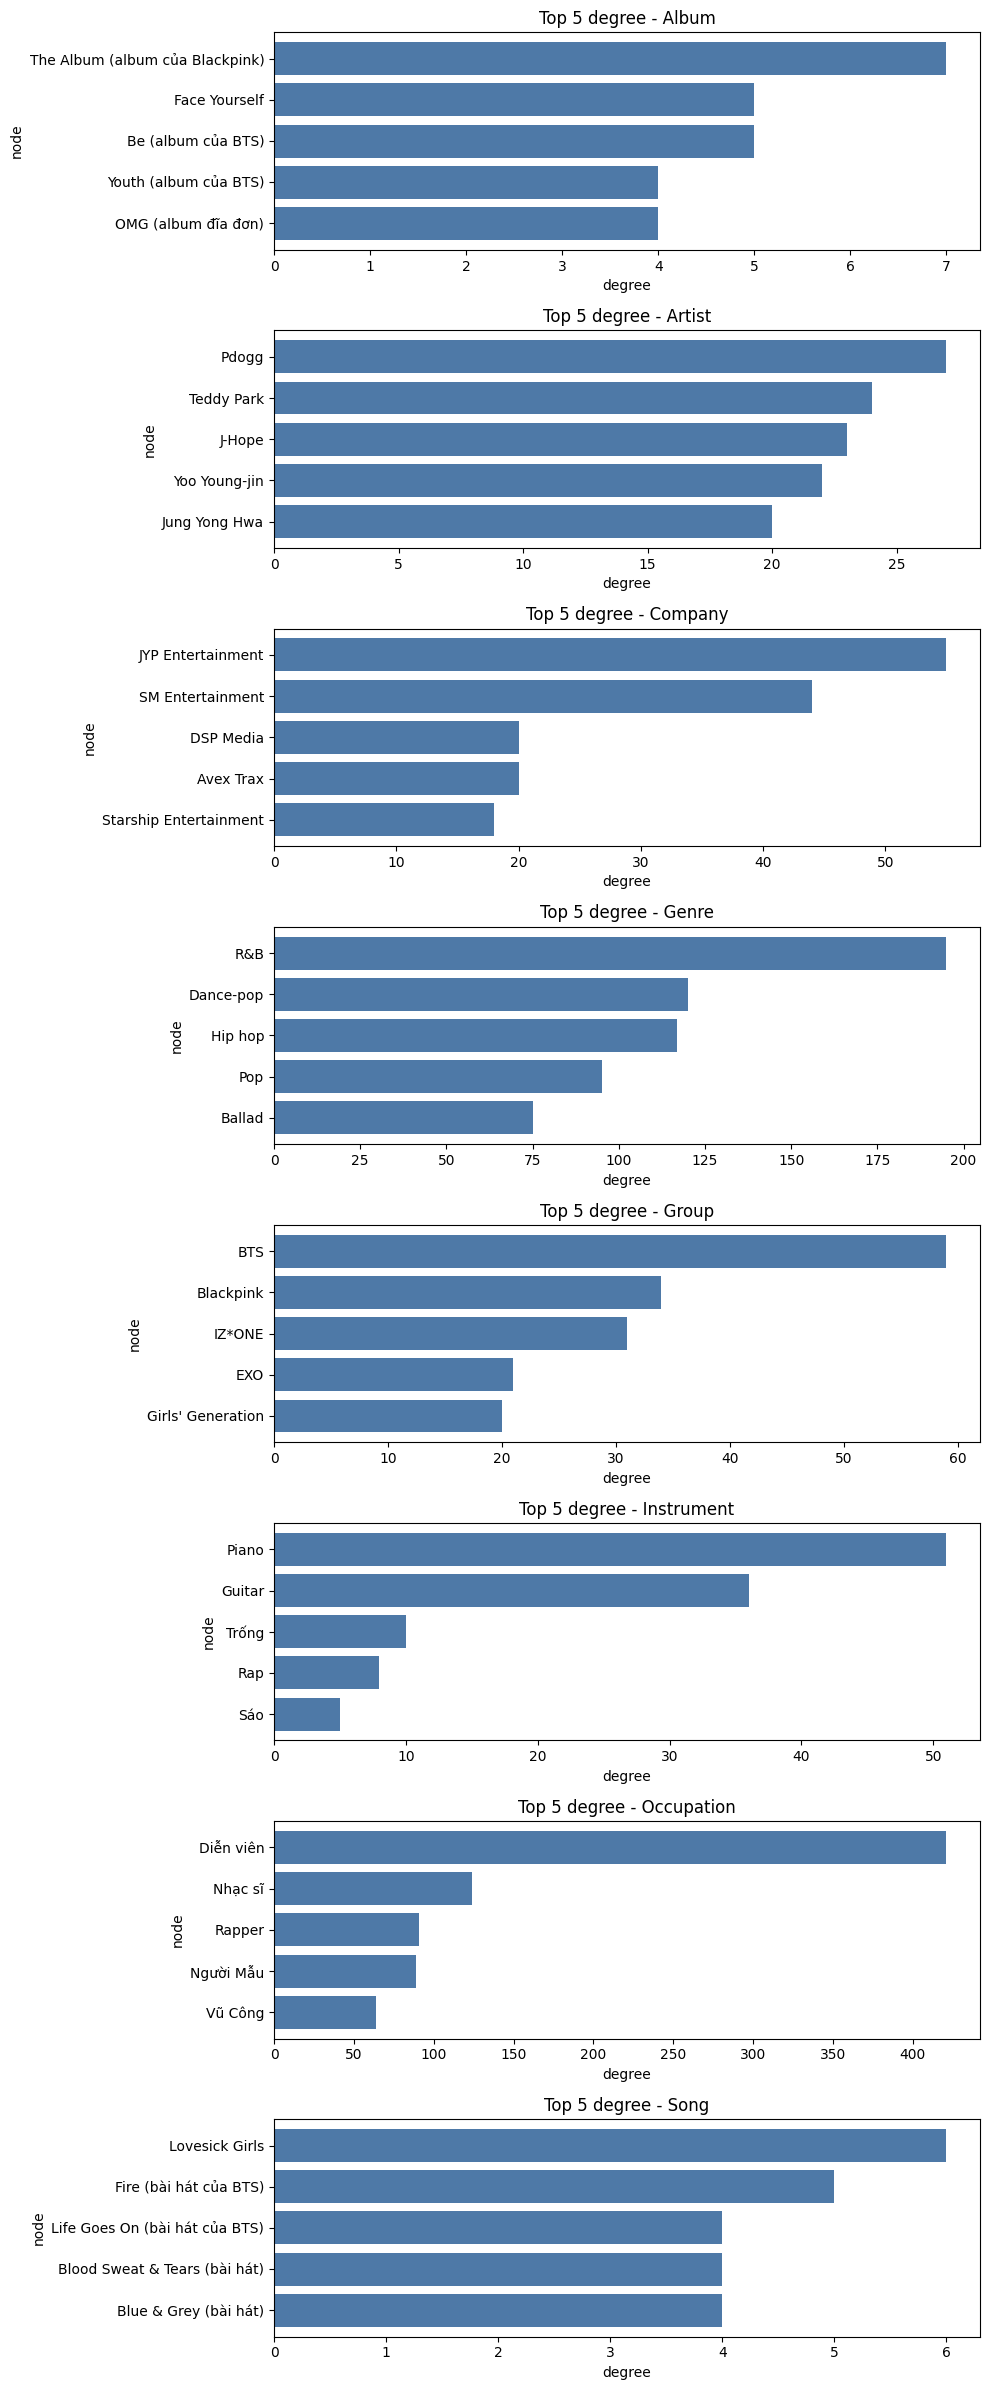

In [15]:
# Biểu đồ Top 5 node theo degree cho mỗi label
if 'top5_by_label' in globals() and not top5_by_label.empty:
    labels = sorted(top5_by_label['label'].unique())
    n = len(labels)
    fig, axes = plt.subplots(n, 1, figsize=(10, 3*n), squeeze=False)
    for i, lbl in enumerate(labels):
        sub = top5_by_label[top5_by_label['label'] == lbl].sort_values('degree')
        axes[i,0].barh(sub['title'], sub['degree'], color='#4E79A7')
        axes[i,0].set_title(f'Top 5 degree - {lbl}')
        axes[i,0].set_xlabel('degree')
        axes[i,0].set_ylabel('node')
    plt.tight_layout(); plt.show()
else:
    print('Chưa có bảng top5_by_label — chạy cell tính top 5 trước.')
